# r4 Data Science Exercise

On August 24th, I spoke with Katie Sullivan in regard to a position as a data scientist with r4. I received this data challenge and here are my results and process.

### First
I began by opening the excel file, noted it had 4 sheets, one of which was data and the rest were related to the challenge itself.

### Second
I chose to complete this in Python as it is becoming my language of choice, I find that employers prefer it to R (which I am generally stronger in), the visualizations are simpler to handle, and I can easily share the Jupyter Notbook with you in a state that demonstrates the outcome of my operations

### Third
I imported libraries to handle the data and began a short EDA (exploratory data analysis) to determine an idea of what I was working with and to approach the questions that I am posed in A and B.

### Fourth
Plan:
    * Observe the frequency distribution of the time periods
    * Find the average number of times a user uses the portal
    * Find the portal page that is most and least frequently viewed
    * Indicate the time periods of use and view the frequency distributions for each page
        * Make a plot for each page's distribution, "hued" by week
        * Check the mean for each period for each page and see if it "shifts"

#### Initial EDA and transformations
* Import data by utilizing Pandas 'read' functionality and select the appropriate sheet of the data
* Conduct a quick view with 'head' (transposed to make it easier to read, this is personal preference)
    * Noted the User_ID is some sort of hash, I prefer to categorize by counting numbers as strings because thy aren't meant to be operated upon (e.g. adding social security numbers doesn't make sense, so looking at them as stringed categories is more appropriate)
    * Data is not dirty, but is fairly uninformative
        * I will need to construct all of the relevant information

# Questions

## A - What can you tell me about this data? What is in this data? (5 - 20 min)

## B - Does Portal Page usage shift week-to-week (relative to when an User first used the service)?  (20 - 90 min)

## C - How would you improve Portal Page engagement of Users (relative how a User uses the service)?  (10 - 30 min)

# Answers

## A
* This data is of a longitudinal nature (panel data in econometrics) such that there are n > 1 observations transitioning over time.
* Each observation contains (what appears to be) a hashed (encrypted by some measure) userID, an organization ID that clusters (or groups) the entities, a first use date signifiying the period of initial use of the portal, a use date signifying the period of use for the observation, and a portal page indicating the page used in the observation.
* Data dimension = 134,950 x 5
    * Number of Unique IDs = n = 2798
    * Number of Observations = N = 134,950
    * Number of Time Periods (days) = T = 34
    * First time period = 2015-01-07
    * Last time period = 2015-02-09

## B

## C

In [29]:
# Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [30]:
# Importing
df = pd.read_excel('/Users/daiglechris/Git/ConvexOptimizationWithPython/Data/DSx.xlsx', sheet_name = 'Data')
df.head(5)

,User_ID,Org_ID,First_Use_Date,Use_Date,Portal_Page
0,07e1e890-947a-42a5-bff6-a6905f6dc2cf-1046-10b2...,P158,2015-01-12,2015-01-12,Discovery Cube
1,07e1e890-947a-42a5-bff6-a6905f6dc2cf-1046-10b2...,P158,2015-01-12,2015-01-12,Discovery Cube
2,07e1e890-947a-42a5-bff6-a6905f6dc2cf-1046-10b2...,P158,2015-01-12,2015-01-12,Discovery Cube
3,07e1e890-947a-42a5-bff6-a6905f6dc2cf-1046-10b2...,P158,2015-01-12,2015-01-12,Discovery Cube
4,07e1e890-947a-42a5-bff6-a6905f6dc2cf-1046-10b2...,P158,2015-01-12,2015-01-12,Discovery Cube


In [31]:
# Control for some naive levels of bad data

# Make sure the data only appears where the fi
df = df[df['First_Use_Date'] <= df['Use_Date']]

# Remove rows with null - the data is fairly uninformative in its current state so replacing null values with anything at this point is not going to help with later analysis
df.dropna(axis=0, how='any', inplace=True)

In [32]:
# Find a few specifics of the data
minDate = df['Use_Date'].min()
maxDate = df['Use_Date'].max()
uniqueDate = df['Use_Date'].nunique()
print('The time span is from {} to {} with {} periods.'.format(minDate, maxDate, uniqueDate))
print()
n = df['User_ID'].nunique()
g = df['Org_ID'].nunique()
avgN = df['User_ID'].value_counts().mean()
print('The number of users is {}, appearing approximately {:,.2f} times, grouped under {} organizations.'.format(n, avgN, g))
print()
pPage = df['Portal_Page'].nunique()
print('There are {} unique portal pages titled: {}.'.format(pPage, list(df['Portal_Page'].unique())))

The time span is from 2015-01-07 00:00:00 to 2015-02-09 00:00:00 with 34 periods.

The number of users is 2798, appearing approximately 48.23 times, grouped under 10 organizations.

There are 6 unique portal pages titled: ['Discovery Cube', 'Fingerprint Chart', 'Mashboard', 'Spider Chart', 'Bullseye Chart', 'Product Recommendation'].


In [33]:
# Add variables for manipulation and for simplicity in viewing

# Use this instead of the hashed User_ID for indexing - just easier for me to view
df['id'] = pd.Categorical((pd.factorize(df['User_ID'])[0] + 1).astype(str))
# start with this as the index as I create other variables and then switch later to Date related indices
df.set_index('id')

#df['group'] = pd.Categorical((pd.factorize(df['Org_ID'])[0] + 1).astype(str))

df['group'] = df['Org_ID'].astype('category').cat.rename_categories(range(1, df['Org_ID'].nunique() + 1))
#df['period'] = pd.Categorical((pd.factorize(df['Use_Date'])[0] + 1).astype(str))
df['period'] = df['Use_Date'].astype('category').cat.rename_categories(range(1, df['Use_Date'].nunique() + 1))
df['week'] = df['Use_Date'].dt.week
df['page'] = pd.Categorical((pd.factorize(df['Portal_Page'])[0] + 1).astype(str))

df.head(5)

,User_ID,Org_ID,First_Use_Date,Use_Date,Portal_Page,id,group,period,week,page
0,07e1e890-947a-42a5-bff6-a6905f6dc2cf-1046-10b2...,P158,2015-01-12,2015-01-12,Discovery Cube,1,7,6,3,1
1,07e1e890-947a-42a5-bff6-a6905f6dc2cf-1046-10b2...,P158,2015-01-12,2015-01-12,Discovery Cube,1,7,6,3,1
2,07e1e890-947a-42a5-bff6-a6905f6dc2cf-1046-10b2...,P158,2015-01-12,2015-01-12,Discovery Cube,1,7,6,3,1
3,07e1e890-947a-42a5-bff6-a6905f6dc2cf-1046-10b2...,P158,2015-01-12,2015-01-12,Discovery Cube,1,7,6,3,1
4,07e1e890-947a-42a5-bff6-a6905f6dc2cf-1046-10b2...,P158,2015-01-12,2015-01-12,Discovery Cube,1,7,6,3,1


In [34]:
df.head()

,User_ID,Org_ID,First_Use_Date,Use_Date,Portal_Page,id,group,period,week,page
0,07e1e890-947a-42a5-bff6-a6905f6dc2cf-1046-10b2...,P158,2015-01-12,2015-01-12,Discovery Cube,1,7,6,3,1
1,07e1e890-947a-42a5-bff6-a6905f6dc2cf-1046-10b2...,P158,2015-01-12,2015-01-12,Discovery Cube,1,7,6,3,1
2,07e1e890-947a-42a5-bff6-a6905f6dc2cf-1046-10b2...,P158,2015-01-12,2015-01-12,Discovery Cube,1,7,6,3,1
3,07e1e890-947a-42a5-bff6-a6905f6dc2cf-1046-10b2...,P158,2015-01-12,2015-01-12,Discovery Cube,1,7,6,3,1
4,07e1e890-947a-42a5-bff6-a6905f6dc2cf-1046-10b2...,P158,2015-01-12,2015-01-12,Discovery Cube,1,7,6,3,1


In [37]:
# Construct variables for overall views grouped by id, dates, pages, and groups

# Total number of days each unique user appears in the data set
numDays = pd.DataFrame(df.groupby('User_ID')['Use_Date'].nunique())
numDays.columns = ['numDays']
df = pd.merge(df, numDays, how = 'inner', on = 'User_ID')

# Total times each unique user appears in the data set
df['totalOverall'] = df.groupby('User_ID')['User_ID'].transform('count')

# Total number of times each unique user accessed a page
df1 = df.groupby(['User_ID','Portal_Page']).count().reset_index()[['User_ID','Portal_Page', 'page']]
df1.rename(columns={'page':'pageCount'}, inplace=True)
df = pd.merge(df,df1, how = 'inner', on = ['User_ID', 'Portal_Page'])

# Total number of times each unique user access a specific page on specific date in the data set
numDaysPage = pd.DataFrame(df.groupby(['Use_Date', 'User_ID'])['Portal_Page'].count().reset_index()[['Use_Date', 'User_ID','Portal_Page']])
numDaysPage.rename(columns={'Portal_Page':'pageCountByDay'}, inplace=True)
df = pd.merge(df, numDaysPage, how = 'inner', on = ['Use_Date', 'User_ID'])

df.head()

,User_ID,Org_ID,First_Use_Date,Use_Date,Portal_Page,id,group,period,week,page,numDays_x,totalOverall,pageCount_x,numDays_y,pageCount_y
0,07e1e890-947a-42a5-bff6-a6905f6dc2cf-1046-10b2...,P158,2015-01-12,2015-01-12,Discovery Cube,1,7,6,3,1,16,61,55,16,55
1,07e1e890-947a-42a5-bff6-a6905f6dc2cf-1046-10b2...,P158,2015-01-12,2015-01-12,Discovery Cube,1,7,6,3,1,16,61,55,16,55
2,07e1e890-947a-42a5-bff6-a6905f6dc2cf-1046-10b2...,P158,2015-01-12,2015-01-12,Discovery Cube,1,7,6,3,1,16,61,55,16,55
3,07e1e890-947a-42a5-bff6-a6905f6dc2cf-1046-10b2...,P158,2015-01-12,2015-01-12,Discovery Cube,1,7,6,3,1,16,61,55,16,55
4,07e1e890-947a-42a5-bff6-a6905f6dc2cf-1046-10b2...,P158,2015-01-12,2015-01-12,Discovery Cube,1,7,6,3,1,16,61,55,16,55


In [8]:
# Average daily portal usage for each unique user
df['avgOverall'] = df['totalOverall'] / df['numDays']

df.head()

In [54]:
# Total number of times each unique user access a specific page on specific date in the data set
numDaysPage = pd.DataFrame(df.groupby(['Use_Date', 'User_ID'])['Portal_Page'].count().reset_index()[['Use_Date', 'User_ID','Portal_Page']])
numDaysPage.rename(columns={'Portal_Page':'pageCountByDay'}, inplace=True)
df1 = pd.merge(df, numDaysPage, how = 'inner', on = ['Use_Date', 'User_ID'])
df1[(df1['id'] == '1') & (df['Portal_Page'] == 'Discovery Cube')].groupby('Use_Date').head()

,User_ID,Org_ID,First_Use_Date,Use_Date,Portal_Page,id,group,period,week,page,numDays_x,totalOverall,pageCount_x,numDays_y,pageCount_y,pageCountByDay
0,07e1e890-947a-42a5-bff6-a6905f6dc2cf-1046-10b2...,P158,2015-01-12,2015-01-12,Discovery Cube,1,7,6,3,1,16,61,55,16,55,11
1,07e1e890-947a-42a5-bff6-a6905f6dc2cf-1046-10b2...,P158,2015-01-12,2015-01-12,Discovery Cube,1,7,6,3,1,16,61,55,16,55,11
2,07e1e890-947a-42a5-bff6-a6905f6dc2cf-1046-10b2...,P158,2015-01-12,2015-01-12,Discovery Cube,1,7,6,3,1,16,61,55,16,55,11
3,07e1e890-947a-42a5-bff6-a6905f6dc2cf-1046-10b2...,P158,2015-01-12,2015-01-12,Discovery Cube,1,7,6,3,1,16,61,55,16,55,11
4,07e1e890-947a-42a5-bff6-a6905f6dc2cf-1046-10b2...,P158,2015-01-12,2015-01-12,Discovery Cube,1,7,6,3,1,16,61,55,16,55,11
11,07e1e890-947a-42a5-bff6-a6905f6dc2cf-1046-10b2...,P158,2015-01-12,2015-01-13,Discovery Cube,1,7,7,3,1,16,61,55,16,55,3
12,07e1e890-947a-42a5-bff6-a6905f6dc2cf-1046-10b2...,P158,2015-01-12,2015-01-13,Discovery Cube,1,7,7,3,1,16,61,55,16,55,3
13,07e1e890-947a-42a5-bff6-a6905f6dc2cf-1046-10b2...,P158,2015-01-12,2015-01-13,Discovery Cube,1,7,7,3,1,16,61,55,16,55,3
14,07e1e890-947a-42a5-bff6-a6905f6dc2cf-1046-10b2...,P158,2015-01-12,2015-01-15,Discovery Cube,1,7,9,3,1,16,61,55,16,55,1
15,07e1e890-947a-42a5-bff6-a6905f6dc2cf-1046-10b2...,P158,2015-01-12,2015-01-16,Discovery Cube,1,7,10,3,1,16,61,55,16,55,10


In [41]:
df1.head()

,User_ID,Org_ID,First_Use_Date,Use_Date,Portal_Page,id,group,period,week,page,numDays_x,totalOverall,pageCount_x,numDays_y,pageCount_y,pageCountByDay
0,07e1e890-947a-42a5-bff6-a6905f6dc2cf-1046-10b2...,P158,2015-01-12,2015-01-12,Discovery Cube,1,7,6,3,1,16,61,55,16,55,11
1,07e1e890-947a-42a5-bff6-a6905f6dc2cf-1046-10b2...,P158,2015-01-12,2015-01-12,Discovery Cube,1,7,6,3,1,16,61,55,16,55,11
2,07e1e890-947a-42a5-bff6-a6905f6dc2cf-1046-10b2...,P158,2015-01-12,2015-01-12,Discovery Cube,1,7,6,3,1,16,61,55,16,55,11
3,07e1e890-947a-42a5-bff6-a6905f6dc2cf-1046-10b2...,P158,2015-01-12,2015-01-12,Discovery Cube,1,7,6,3,1,16,61,55,16,55,11
4,07e1e890-947a-42a5-bff6-a6905f6dc2cf-1046-10b2...,P158,2015-01-12,2015-01-12,Discovery Cube,1,7,6,3,1,16,61,55,16,55,11


In [78]:
df2.head()

,index,User_ID,Org_ID,First_Use_Date,Use_Date,Portal_Page,id,group,period,week,page
0,0,07e1e890-947a-42a5-bff6-a6905f6dc2cf-1046-10b2...,P158,2015-01-12,2015-01-12,Discovery Cube,1,7,6,3,1
1,1,07e1e890-947a-42a5-bff6-a6905f6dc2cf-1046-10b2...,P158,2015-01-12,2015-01-12,Discovery Cube,1,7,6,3,1
2,2,07e1e890-947a-42a5-bff6-a6905f6dc2cf-1046-10b2...,P158,2015-01-12,2015-01-12,Discovery Cube,1,7,6,3,1
3,3,07e1e890-947a-42a5-bff6-a6905f6dc2cf-1046-10b2...,P158,2015-01-12,2015-01-12,Discovery Cube,1,7,6,3,1
4,4,07e1e890-947a-42a5-bff6-a6905f6dc2cf-1046-10b2...,P158,2015-01-12,2015-01-12,Discovery Cube,1,7,6,3,1


In [77]:
df1.head()

,User_ID,Portal_Page,pageCount
0,07e1e890-947a-42a5-bff6-a6905f6dc2cf-1046-10b2...,Discovery Cube,55
1,07e1e890-947a-42a5-bff6-a6905f6dc2cf-1046-10b2...,Fingerprint Chart,5
2,07e1e890-947a-42a5-bff6-a6905f6dc2cf-1046-10b2...,Mashboard,1
3,07e1e890-947a-42a5-bff6-a6905f6dc2cf-1112-22a5...,Discovery Cube,83
4,07e1e890-947a-42a5-bff6-a6905f6dc2cf-1112-22a5...,Fingerprint Chart,2


In [71]:
df1['Portal_Page'] == df2['Portal_Page']

ValueError: Can only compare identically-labeled Series objects

In [59]:
df.groupby(['User_ID','Portal_Page']).count().reset_index()

,User_ID,Portal_Page,Org_ID,First_Use_Date,Use_Date,id,group,period,week,page
0,07e1e890-947a-42a5-bff6-a6905f6dc2cf-1046-10b2...,Discovery Cube,55,55,55,55,55,55,55,55
1,07e1e890-947a-42a5-bff6-a6905f6dc2cf-1046-10b2...,Fingerprint Chart,5,5,5,5,5,5,5,5
2,07e1e890-947a-42a5-bff6-a6905f6dc2cf-1046-10b2...,Mashboard,1,1,1,1,1,1,1,1
3,07e1e890-947a-42a5-bff6-a6905f6dc2cf-1112-22a5...,Discovery Cube,83,83,83,83,83,83,83,83
4,07e1e890-947a-42a5-bff6-a6905f6dc2cf-1112-22a5...,Fingerprint Chart,2,2,2,2,2,2,2,2
5,07e1e890-947a-42a5-bff6-a6905f6dc2cf-1112-22a5...,Mashboard,1,1,1,1,1,1,1,1
6,07e1e890-947a-42a5-bff6-a6905f6dc2cf-1128-d1c1...,Discovery Cube,8,8,8,8,8,8,8,8
7,07e1e890-947a-42a5-bff6-a6905f6dc2cf-1128-d1c1...,Fingerprint Chart,5,5,5,5,5,5,5,5
8,07e1e890-947a-42a5-bff6-a6905f6dc2cf-1135-45bd...,Discovery Cube,103,103,103,103,103,103,103,103
9,07e1e890-947a-42a5-bff6-a6905f6dc2cf-1167-eeb0...,Discovery Cube,3,3,3,3,3,3,3,3


/Users/mbair/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


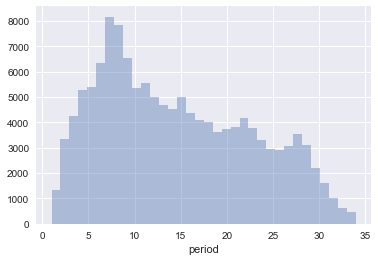

In [6]:
sns.distplot(df['period'], kde = False, bins = 34, hist = True)

In [7]:
df.pivot_table(values=df['Portal_Page'].value_counts(), index='Use_Date', columns=['Org_ID', 'Portal_Page'])

KeyError: 105489

In [19]:
df['Portal_Page'].value_counts()

Discovery Cube            105489
Fingerprint Chart          21802
Product Recommendation      2711
Mashboard                   2339
Spider Chart                1426
Bullseye Chart              1183
Name: Portal_Page, dtype: int64

In [45]:
df1 = df.groupby('Use_Date')['page'].value_counts()
df2 = df.groupby('Use_Date')['id'].value_counts()
df3 = df.groupby('Use_Date')['group'].value_counts()
sns.distplot(df1)

TypeError: distplot() got an unexpected keyword argument 'hue'

/Users/daiglechris/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


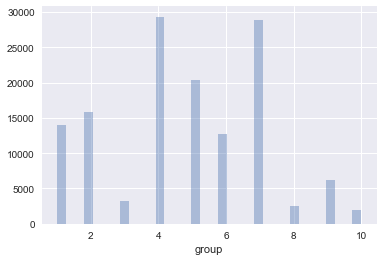

In [56]:
sns.distplot(df['group'].astype(int), kde = False, bins = 34, hist = True)

In [48]:
sns.scatterplot(df['group'].astype(int), kde = False, bins = 34, hist = True)

AttributeError: module 'seaborn' has no attribute 'scatterplot'